# Mole detection

In [1]:
import os

from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Dropout,Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import vgg16, mobilenet_v2
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix, roc_curve, accuracy_score

from cv2 import bilateralFilter

If you run this notebook from Google Colab, make sure to have the correct labeled dataset at the root of your Google Drive, to use this notebook without modifying paths.

In [2]:
try:
  from google.colab import drive
  IN_COLAB = True
except:
  IN_COLAB = False

We make sure to use our GPU if we have one.

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


We define the base for the subsquent paths based on wether we run thos on Colab or on a local machine

In [4]:
if IN_COLAB:
    drive.mount('/content/drive/')
    base_path = '/content/drive/MyDrive'
else:
    base_path = '.'

We define the paths from which we'll pick the images.

In [5]:
# paths definition
dataset_path = os.path.join(base_path, 'labeled_dataset')
train_path = os.path.join(dataset_path, 'train')
valid_path = os.path.join(dataset_path, 'valid')
test_path = os.path.join(dataset_path, 'test')

Let's define some constants for our models.

In [6]:
# model constants definition
CLASSES = ['malignant', 'benign']
INPUT_SIZE = (224, 224)
INPUT_SHAPE = INPUT_SIZE + (3,)
BATCH_SIZE = 32
EPOCHS = 20

The following function is a pre-processing function whih will be applied to every image before being fed as an input.

In [7]:
D = 9
SIGMACOLOR = 75
SIGMASPACE = 75


def preprocess_mobilenet(image):
  image = bilateralFilter(image, d=D, sigmaColor=SIGMACOLOR, sigmaSpace=SIGMASPACE)
  image = mobilenet_v2.preprocess_input(image, data_format=None)
  return image


Let's define three generators based on our specific file hierarchy. One for each of these categories: training set, validation set and testing set.

In [8]:
# train_batches = ImageDataGenerator(
#     preprocessing_function=vgg16.preprocess_input).flow_from_directory(
#         train_path, 
#         target_size = INPUT_SIZE, 
#         classes = CLASSES, 
#         shuffle = True,
#         batch_size = BATCH_SIZE)
# valid_batches = ImageDataGenerator(
#     preprocessing_function=vgg16.preprocess_input).flow_from_directory(
#         valid_path, 
#         target_size = INPUT_SIZE, 
#         classes=CLASSES, 
#         shuffle = True,
#         batch_size = BATCH_SIZE)
# test_batches = ImageDataGenerator(
#     preprocessing_function=vgg16.preprocess_input).flow_from_directory(
#         test_path, 
#         target_size = INPUT_SIZE, 
#         classes = CLASSES, 
#         shuffle = False,
#         batch_size = BATCH_SIZE)

The following function is to plot a batch of preprocessed training data.

In [9]:
# # plots images with labels within jupyter notebook
# def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
#     if type(ims[0]) is np.ndarray:
#         ims = np.array(ims).astype(np.uint8)
#         if (ims.shape[-1] != 3):
#             ims = ims.transpose((0,2,3,1))
#     f = plt.figure(figsize=figsize)
#     cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
#     for i in range(len(ims)):
#         sp = f.add_subplot(rows, cols, i+1)
#         sp.axis('Off')
#         if titles is not None:
#             sp.set_title(titles[i], fontsize=16)
#         plt.imshow(ims[i], interpolation=None if interp else 'none')

Let's use it as a test on the first batch to see what the images look like.

In [10]:
# class_dict = train_batches.class_indices
# imgs, labels = next(train_batches)
# titles = ['benign' if x[class_dict['benign']]==1 else 'malignant' for x in labels]
# plots(imgs, figsize=(36,18), titles=titles, rows=4)

In [11]:
# imgs[0]
# plt.imshow(imgs[0])

In [12]:
# model = Sequential()
# base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
# model.add(base_model)
# model.layers[0].summary()

In [13]:
# model.add(Flatten())
# model.add(Dense(256,activation='relu'))
# model.add(Dropout(0.1))
# model.add(Dense(2, activation='softmax'))
# model.summary()

In [14]:
# for layers in model.layers[0].layers: # looping over each layers in layer 0 to freeze them
#   layers.trainable = False

# model.layers[0].trainable = False

In [15]:
# model.summary()

In [16]:
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
# model.fit(train_batches, 
#           steps_per_epoch = len(train_batches.filenames)//BATCH_SIZE, 
#           epochs = EPOCHS, 
#           validation_data = valid_batches, 
#           validation_steps = len(test_batches.filenames)//BATCH_SIZE
#           )
          

In [18]:
# acc = model.history.history['accuracy']
# val_acc = model.history.history['val_accuracy']

# loss = model.history.history['loss']
# val_loss = model.history.history['val_loss']

In [19]:
# epochs_range = range(EPOCHS)

# plt.figure(figsize=(18, 9))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()


In [20]:
train_batches = ImageDataGenerator(
    rotation_range = 20, 
    width_shift_range = 0.1, 
    height_shift_range = 0.1, 
    shear_range = 0.1, 
    zoom_range = 0.2, 
    horizontal_flip = True, 
    vertical_flip = True,
    preprocessing_function = preprocess_mobilenet).flow_from_directory(
        train_path, 
        target_size = INPUT_SIZE, 
        classes = CLASSES, 
        shuffle = True,
        batch_size = BATCH_SIZE)
valid_batches = ImageDataGenerator(
    preprocessing_function = preprocess_mobilenet).flow_from_directory(
        valid_path, 
        target_size = INPUT_SIZE, 
        classes = CLASSES,
        shuffle = True,
        batch_size = BATCH_SIZE)
test_batches = ImageDataGenerator(
    preprocessing_function = preprocess_mobilenet).flow_from_directory(
        test_path, 
        target_size = INPUT_SIZE, 
        classes = CLASSES, 
        shuffle = False,
        batch_size = BATCH_SIZE)

Found 2177 images belonging to 2 classes.
Found 434 images belonging to 2 classes.
Found 289 images belonging to 2 classes.


In [21]:
model = Sequential()
base_model = mobilenet_v2.MobileNetV2(weights='imagenet',include_top=False, input_shape=INPUT_SHAPE)
model.add(base_model)
model.layers[0].summary()

_relu[0][0]        
__________________________________________________________________________________________________
block_6_depthwise (DepthwiseCon (None, 14, 14, 192)  1728        block_6_pad[0][0]                
__________________________________________________________________________________________________
block_6_depthwise_BN (BatchNorm (None, 14, 14, 192)  768         block_6_depthwise[0][0]          
__________________________________________________________________________________________________
block_6_depthwise_relu (ReLU)   (None, 14, 14, 192)  0           block_6_depthwise_BN[0][0]       
__________________________________________________________________________________________________
block_6_project (Conv2D)        (None, 14, 14, 64)   12288       block_6_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_6_project_BN (BatchNormal (None, 14, 14, 64)   256         block_6_project[0][0]   

In [22]:
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               16056576  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 18,315,074
Trainable params: 18,280,962
Non-trainable params: 34,112
_________________________________________________________________


In [23]:
for layers in model.layers[0].layers: # looping over each layers in layer 0 to freeze them
  layers.trainable = False

model.layers[0].trainable = False

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               16056576  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 18,315,074
Trainable params: 16,057,090
Non-trainable params: 2,257,984
_________________________________________________________________


In [25]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [27]:
model.fit(train_batches, 
          steps_per_epoch = len(train_batches.filenames)//BATCH_SIZE, 
          epochs = EPOCHS, 
          validation_data = valid_batches, 
          validation_steps = len(test_batches.filenames)//BATCH_SIZE, 
          class_weight = {0:3, 1:1}, 
          # callbacks = [es]
          verbose =1 ,
          )

Epoch 1/20
68/68 [==============================] - 49s 554ms/step - loss: 14.1710 - accuracy: 0.5868 - val_loss: 0.5151 - val_accuracy: 0.8056
Epoch 2/20
68/68 [==============================] - 27s 409ms/step - loss: 0.8672 - accuracy: 0.7106 - val_loss: 0.4978 - val_accuracy: 0.7743
Epoch 3/20
68/68 [==============================] - 29s 417ms/step - loss: 0.8618 - accuracy: 0.6843 - val_loss: 0.5033 - val_accuracy: 0.7847
Epoch 4/20
68/68 [==============================] - 29s 427ms/step - loss: 0.8354 - accuracy: 0.7057 - val_loss: 0.4243 - val_accuracy: 0.7812
Epoch 5/20
68/68 [==============================] - 29s 431ms/step - loss: 0.8259 - accuracy: 0.7176 - val_loss: 0.4861 - val_accuracy: 0.7465
Epoch 6/20
68/68 [==============================] - 30s 433ms/step - loss: 0.8387 - accuracy: 0.6824 - val_loss: 0.5451 - val_accuracy: 0.7153
Epoch 7/20
68/68 [==============================] - 30s 440ms/step - loss: 0.7740 - accuracy: 0.7276 - val_loss: 0.5329 - val_accuracy: 0.739

In [28]:
acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']

loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

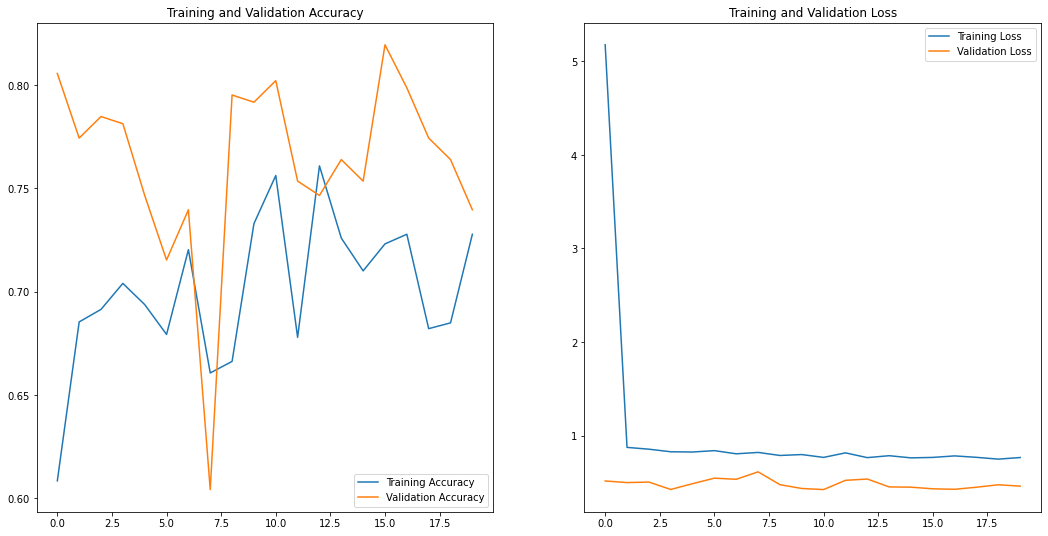

In [29]:
epochs_range = range(EPOCHS)

plt.figure(figsize=(18, 9))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [30]:
# model.save('temp_model3.h5')

In [31]:
test_steps_per_epoch = np.math.ceil(test_batches.samples / test_batches.batch_size)

In [32]:
predictions = model.predict(x=test_batches, steps=test_steps_per_epoch)

In [33]:
predicted_classes = np.argmax(predictions, axis=1)
predicted_classes

array([0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 1])

In [34]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred = predictions.argmax(axis=1))

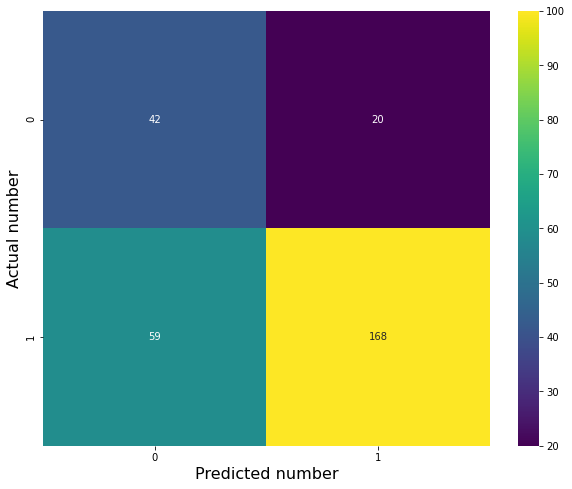

In [35]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, cmap="viridis", vmax=100, annot=True, fmt='g')
plt.gca().set_xlabel("Predicted number", fontsize=16)
plt.gca().set_ylabel("Actual number", fontsize = 16)
plt.show()